In [1]:
import individual_files_module
import main_module

In [2]:
file_path = 'Data/LaFleur_supp.csv'
df = main_module.load_and_preprocess_data(file_path)

In [3]:
split_data, file_names = main_module.split_data_by_file(df)

In [4]:
# all_results = individual_files_module.repeat_evalute_each_file(file_names, split_data, 10)
# individual_files_module.save_repeat_evalute_each_file(all_results)
# individual_files_module.save_repeat_evalute_each_file_statistics(all_results, split_data, file_names)

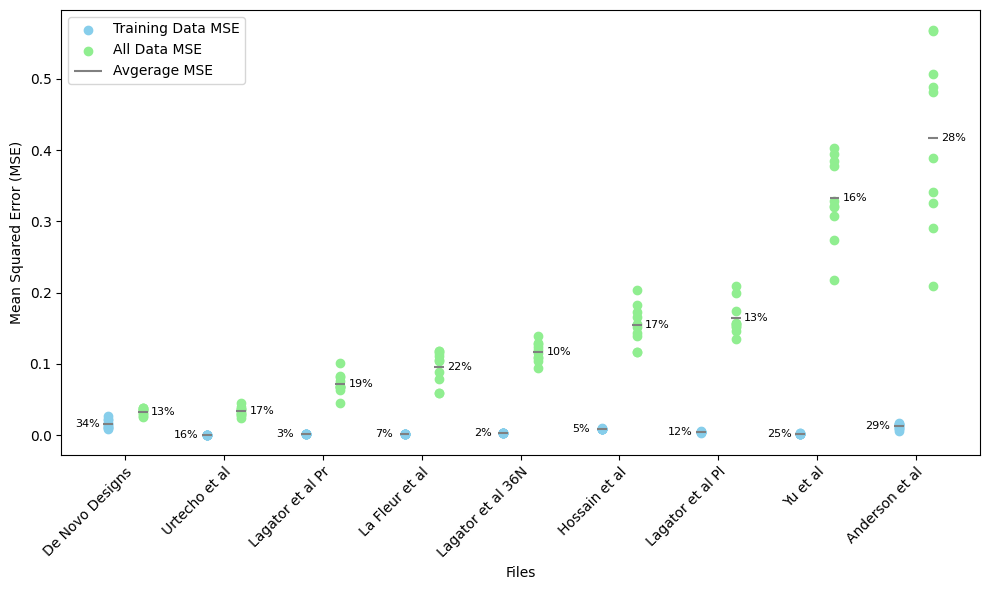

In [5]:
all_results = individual_files_module.load_repeat_evalute_each_file()
file_order = individual_files_module.plot_repeat_evalute_each_file(file_names, all_results)

### Notes

Here, we explore what can affect the model's MSE when evaluated on it's own data and on the rest of the data. We initially assumed a large dataset would produce a model that is good at predicting the rest of the data, since Anderson et al. has 18 promoters. However, De Novo Designs only has 35 and has the lowest MSE when evaluated on the rest of the data. It also has a relatively high MSE when evaluated on its own data. Here, we compare each dataset's:
- Size
- Motif diversity
- Motif uniqueness
- Observed log(TX/Txref) distribution
- Average sequence length

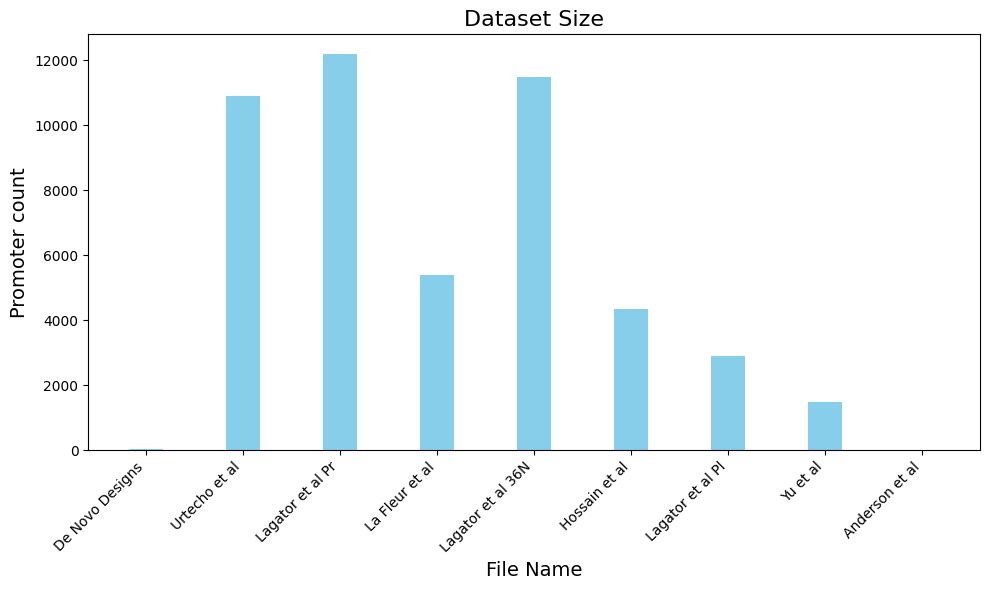

In [6]:
file_sequence_counts = individual_files_module.get_file_sequence_counts(df)
individual_files_module.file_bar_chart(file_sequence_counts, file_order, y_label='Promoter count', title='Dataset Size')

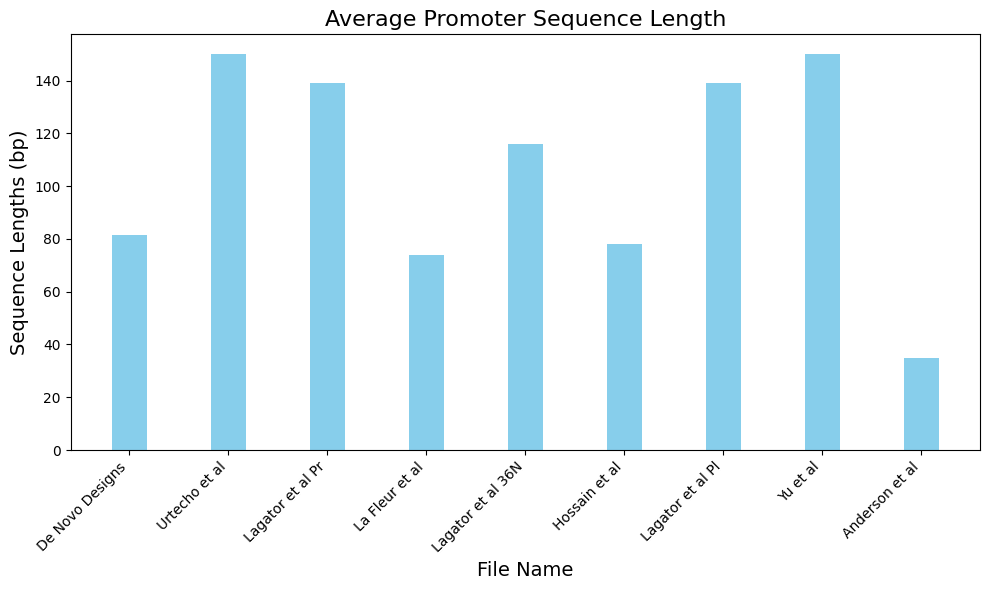

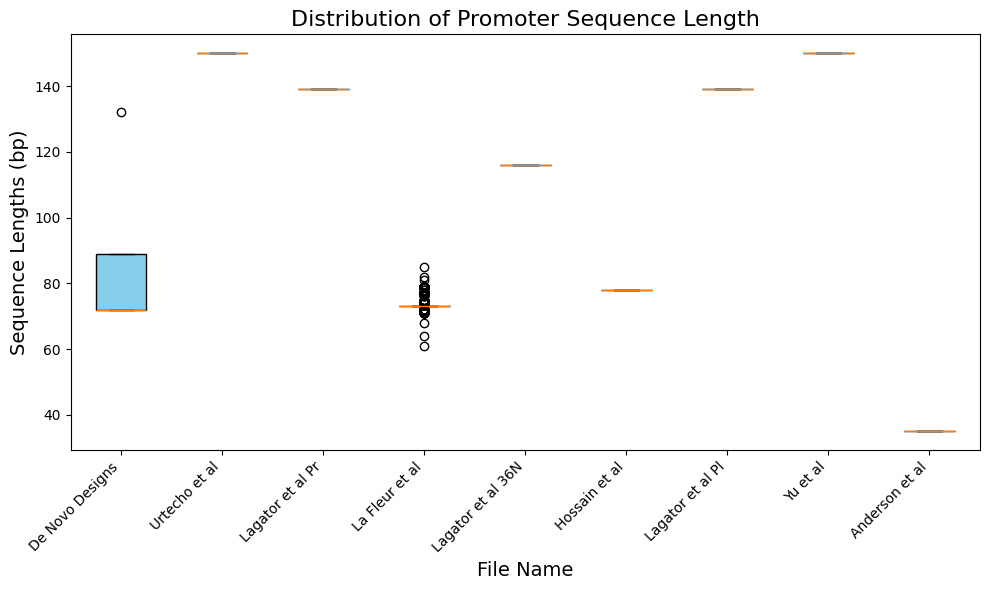

In [7]:
sequence_lengths = individual_files_module.get_promoter_sequence_lengths(df)
average_sequence_lengths = {file : sum(lengths) / len(lengths) for file, lengths in sequence_lengths.items()}

individual_files_module.file_bar_chart(average_sequence_lengths, file_order, y_label='Sequence Lengths (bp)', title='Average Promoter Sequence Length')
individual_files_module.file_box_plot(sequence_lengths, file_order, y_label='Sequence Lengths (bp)', title='Distribution of Promoter Sequence Length')

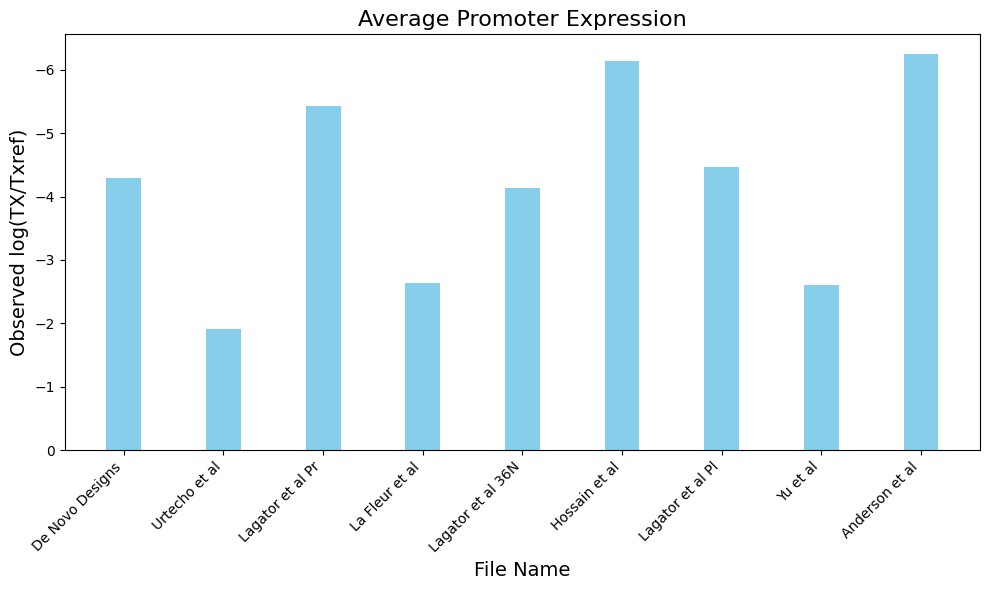

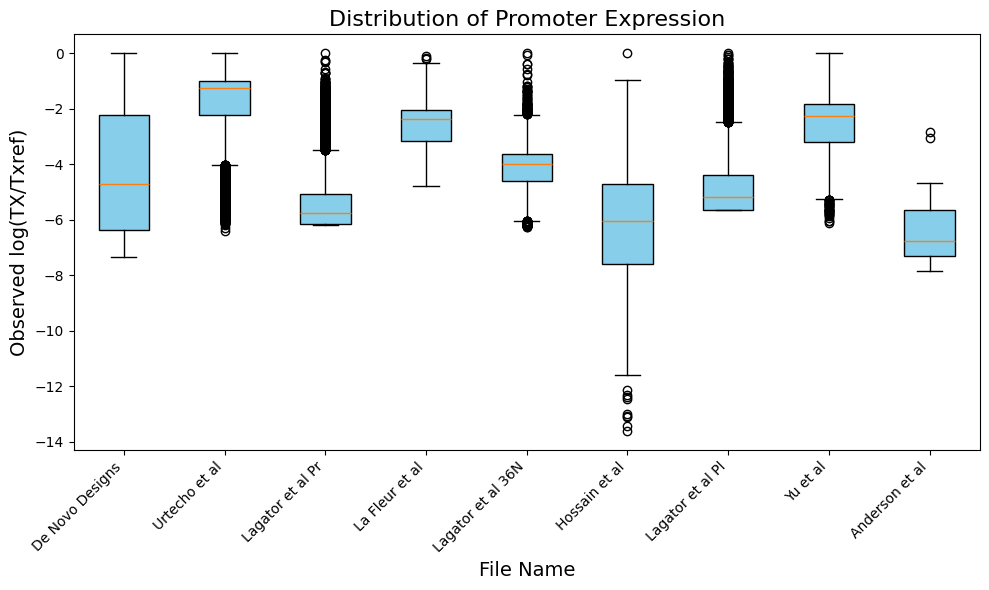

In [8]:
observed_expressions = individual_files_module.get_observed_expressions(df)
average_observed_expressions = {file : sum(lengths) / len(lengths) for file, lengths in observed_expressions.items()}

individual_files_module.file_bar_chart(average_observed_expressions, file_order, y_label='Observed log(TX/Txref)', title='Average Promoter Expression')
individual_files_module.file_box_plot(observed_expressions, file_order, y_label='Observed log(TX/Txref)', title='Distribution of Promoter Expression')

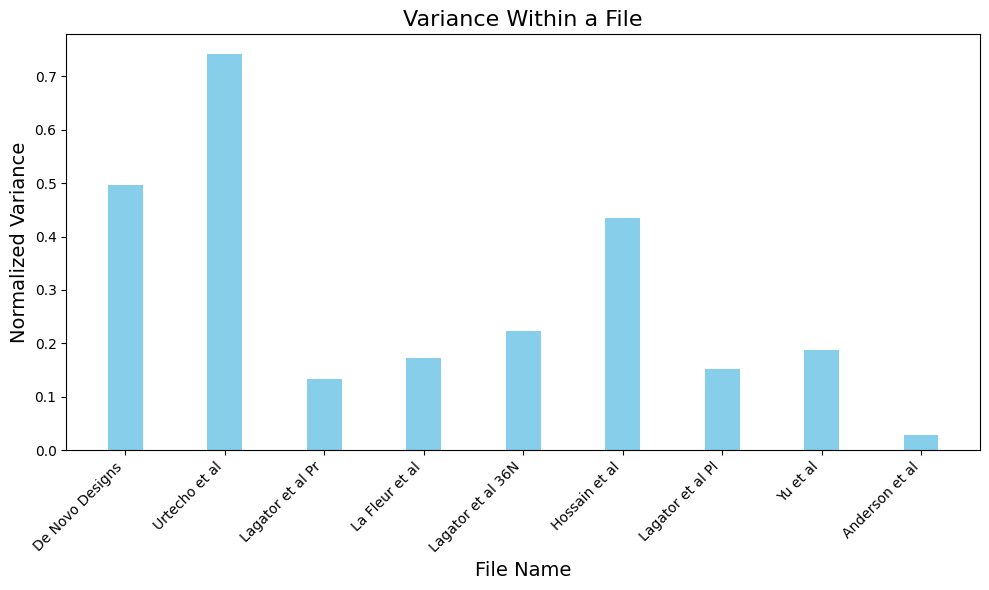

In [9]:
inter_file_variance = individual_files_module.get_inter_file_variance(df, normalize=False)
individual_files_module.file_bar_chart(inter_file_variance, file_order, y_label='Normalized Variance', title='Variance Within a File')

In [10]:
def relative_hamming_distance(seq1, seq2):
    min_length = min(len(seq1), len(seq2))
    max_length = max(len(seq1), len(seq2))
    distance = sum(c1 != c2 for c1, c2 in zip(seq1[:min_length], seq2[:min_length])) + (max_length - min_length)
    return distance / max_length

def hamming_distance(seq1, seq2):
    min_length = min(len(seq1), len(seq2))
    max_length = max(len(seq1), len(seq2))
    return sum(c1 != c2 for c1, c2 in zip(seq1[:min_length], seq2[:min_length])) + (max_length - min_length)

def levenshtein_distance(seq1, seq2):
    '''
    Levenshtein Distance is a string metric for measuring the difference between two sequences.
    Informally, the Levenshtein distance between two words is the minimum number of single-character edits
    (insertions, deletions, or substitutions) required to change one word into the other.
    '''
    len_seq1 = len(seq1) + 1
    len_seq2 = len(seq2) + 1

    dp = [[0 for _ in range(len_seq2)] for _ in range(len_seq1)]

    for i in range(len_seq1):
        dp[i][0] = i
    for j in range(len_seq2):
        dp[0][j] = j

    for i in range(1, len_seq1):
        for j in range(1, len_seq2):
            cost = 0 if seq1[i - 1] == seq2[j - 1] else 1

            dp[i][j] = min(
                dp[i - 1][j] + 1,
                dp[i][j - 1] + 1,
                dp[i - 1][j - 1] + cost
            )

    return dp[-1][-1]

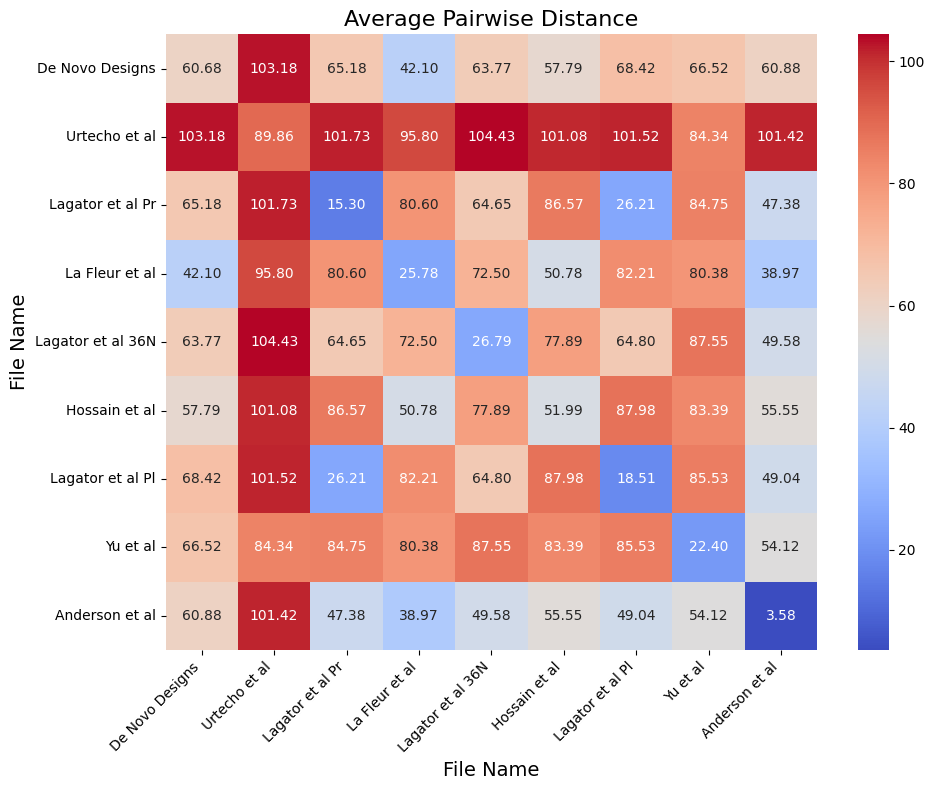

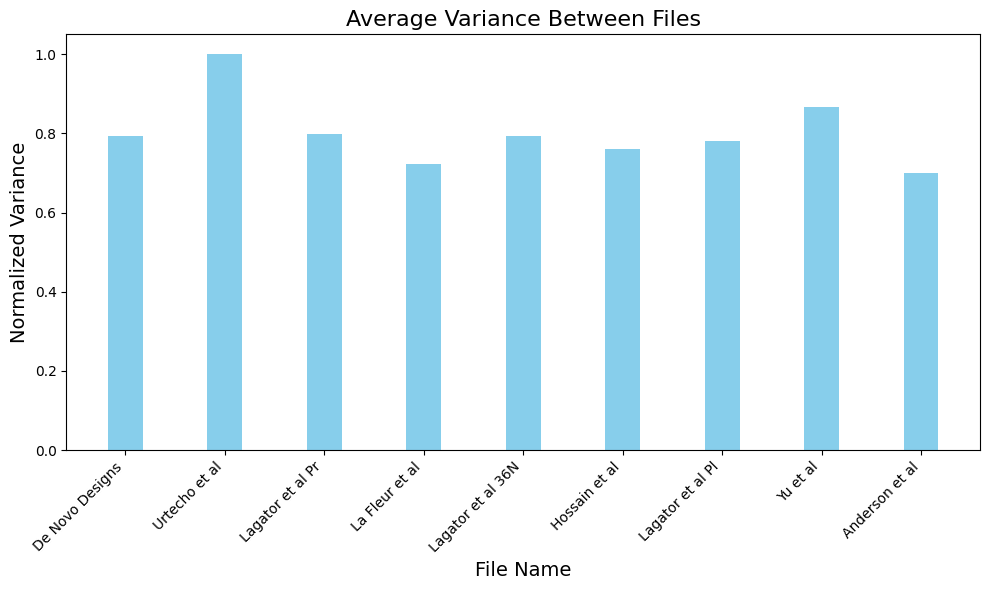

In [23]:
individual_files_module.plot_pairwise_file_distance(df, order=file_order, n=100, function=hamming_distance)

average_pairwise_distances = individual_files_module.get_average_pairwise_distances(df, n=10, pad=True, exclude_self=True, function=hamming_distance, normalize=True)
individual_files_module.file_bar_chart(average_pairwise_distances, file_order, y_label='Normalized Variance', title='Average Variance Between Files')

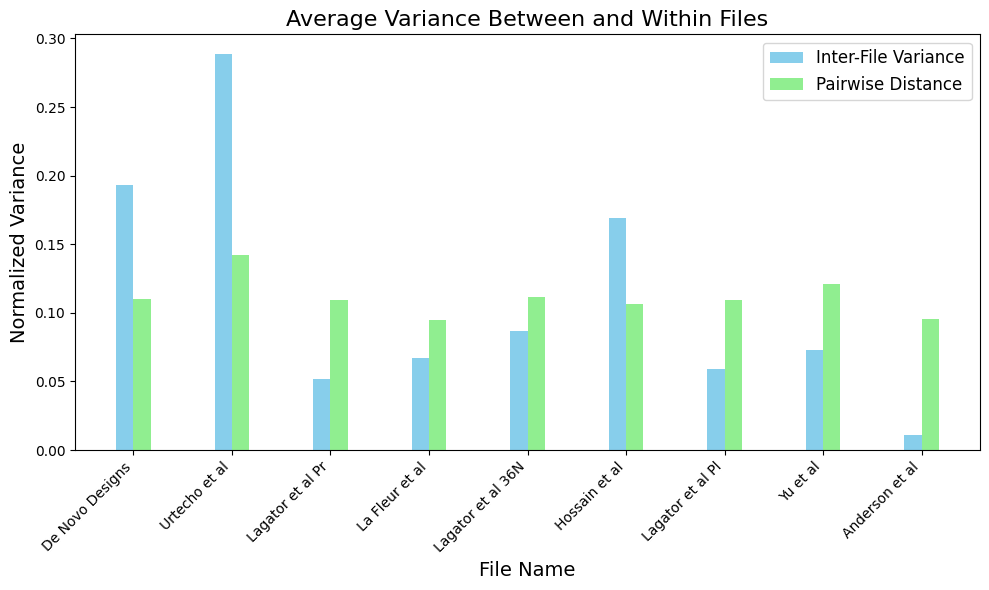

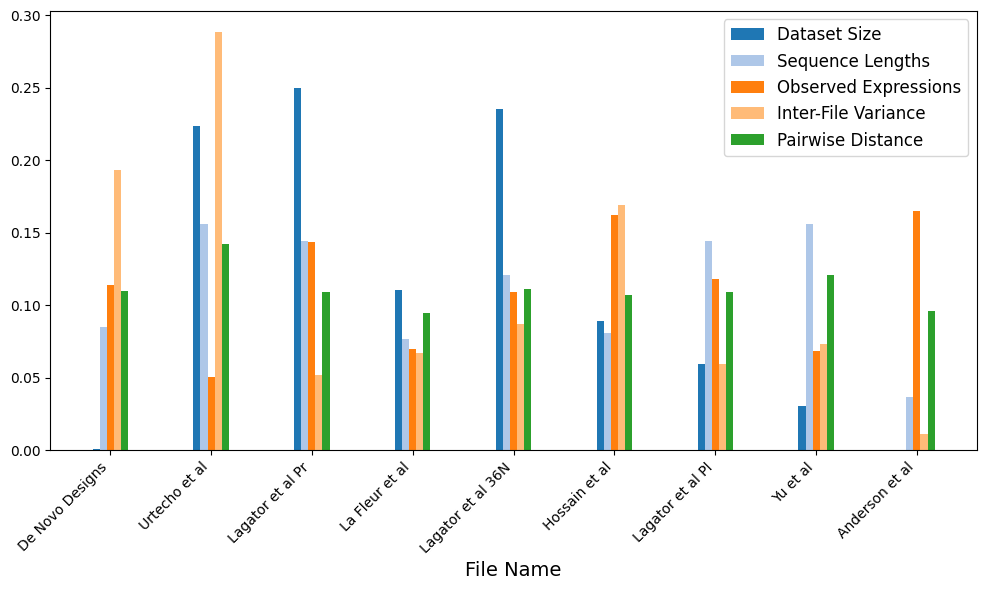

In [20]:
data = {
    'Inter-File Variance' : inter_file_variance,
    'Pairwise Distance' : average_pairwise_distances,
}
colors = {
    'Inter-File Variance' : 'skyblue',
    'Pairwise Distance' : 'lightgreen',
}
individual_files_module.multiple_bar_chart(data, file_order, y_label='Normalized Variance', title='Average Variance Between and Within Files', colors=colors)

data = {
    'Dataset Size' : file_sequence_counts,
    'Sequence Lengths' : average_sequence_lengths,
    'Observed Expressions' : average_observed_expressions,
    'Inter-File Variance' : inter_file_variance,
    'Pairwise Distance' : average_pairwise_distances,
}
individual_files_module.multiple_bar_chart(data, file_order, y_label='', title='')


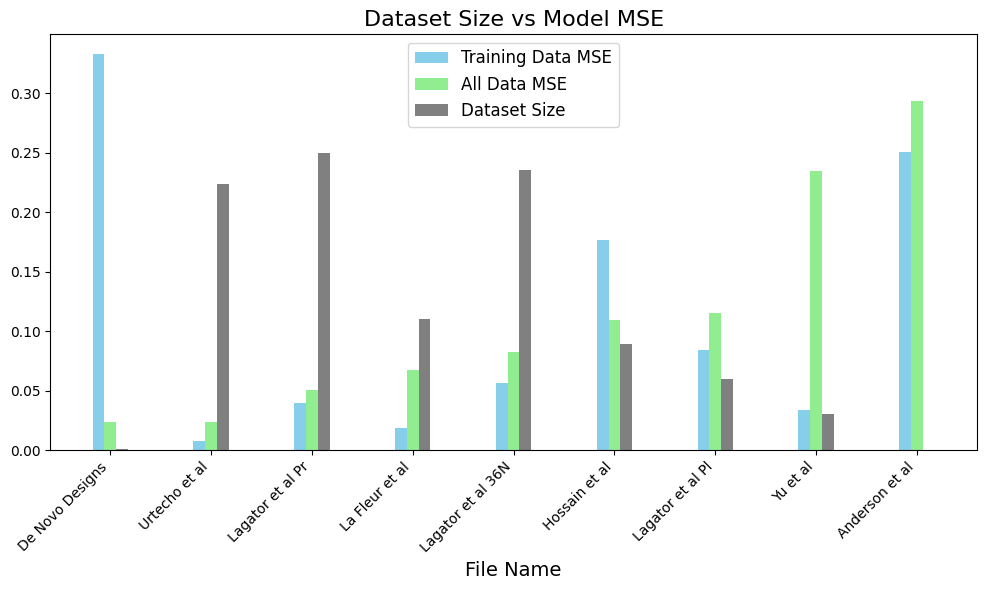

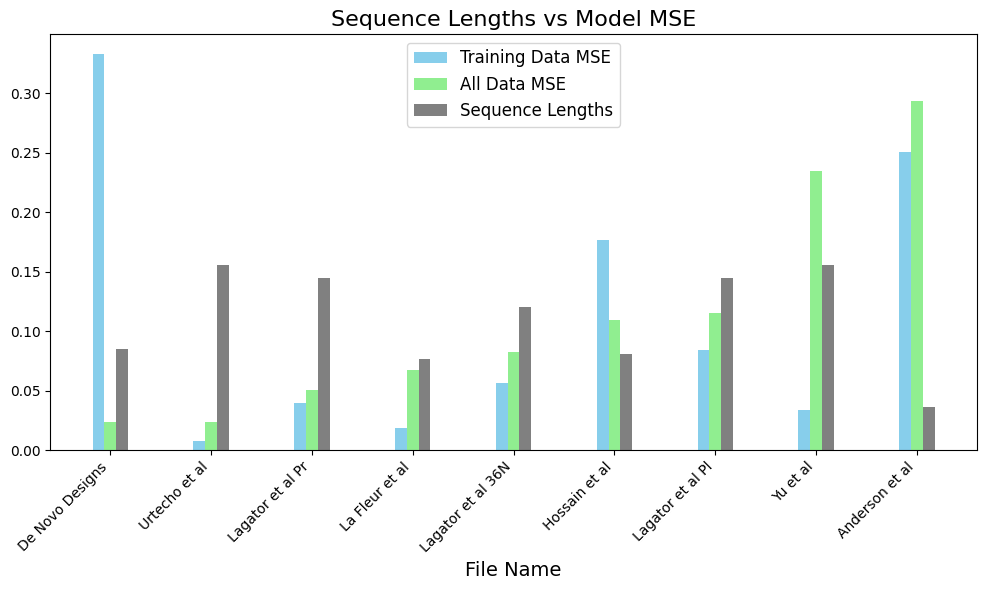

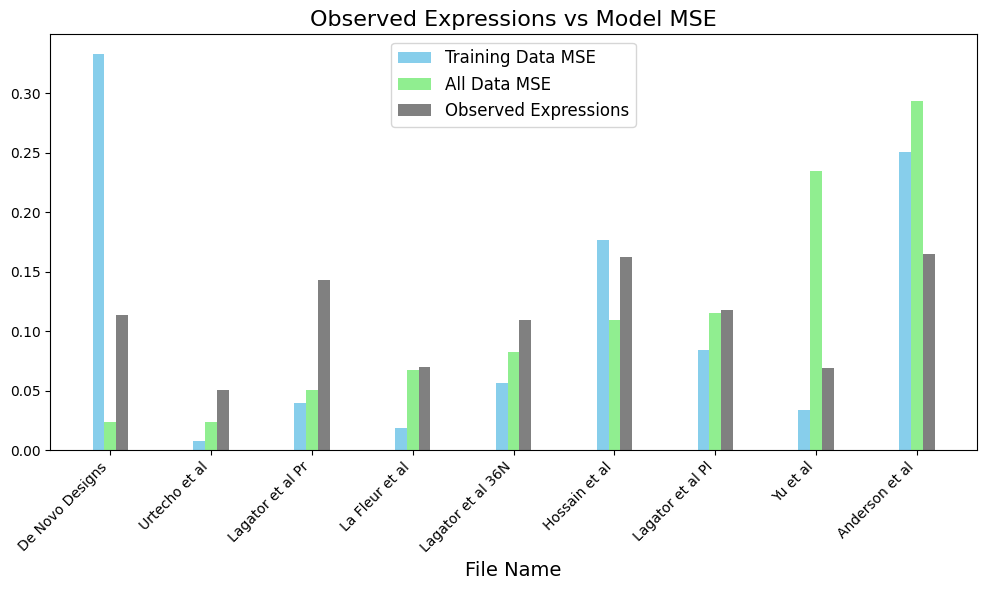

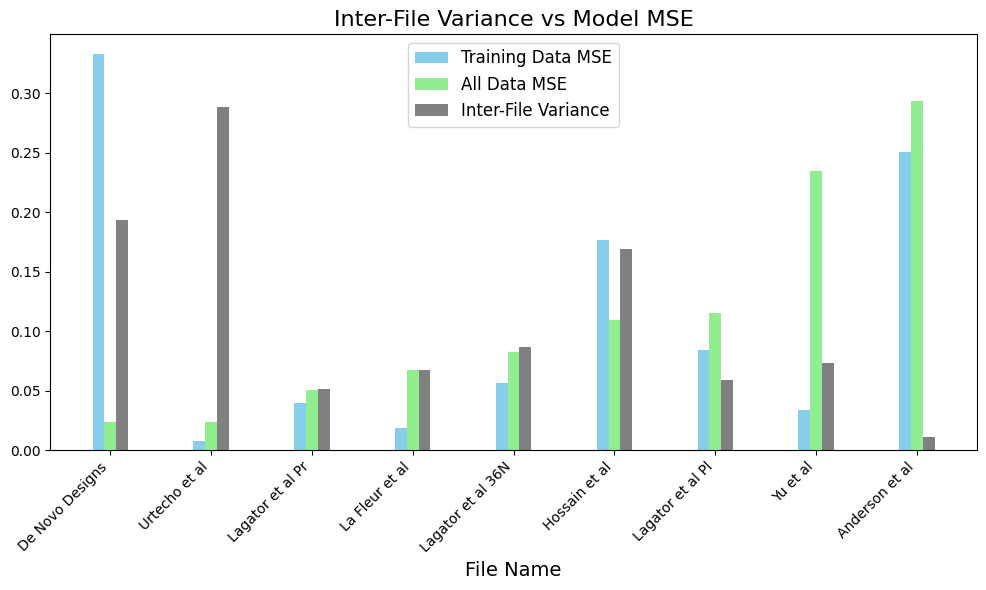

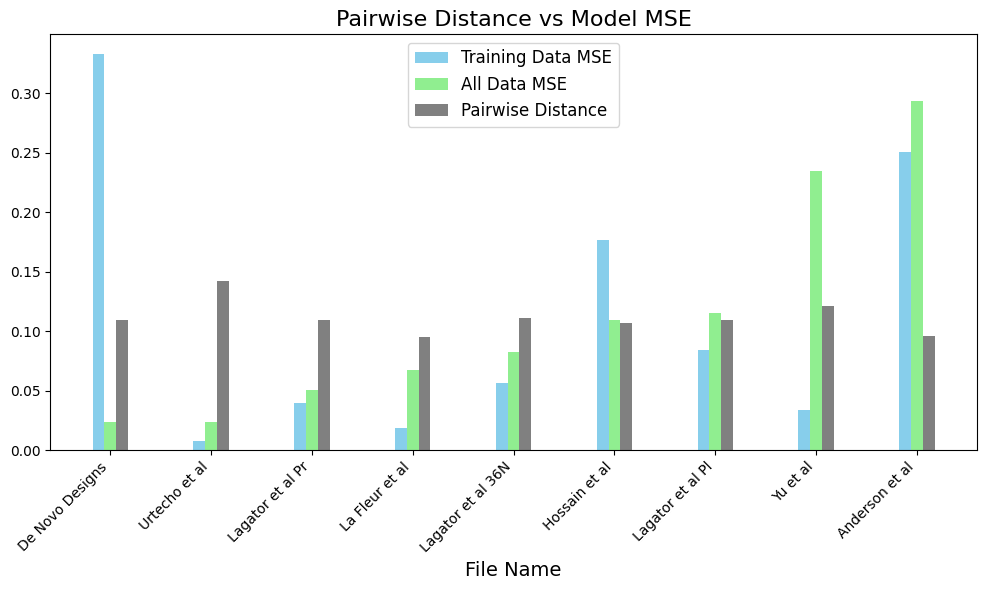

In [13]:
metrics = {
    'Dataset Size' : file_sequence_counts,
    'Sequence Lengths' : average_sequence_lengths,
    'Observed Expressions' : average_observed_expressions,
    'Inter-File Variance' : inter_file_variance,
    'Pairwise Distance' : average_pairwise_distances,
}

individual_files_module.plot_metric_mse(metrics, file_order, all_results)

In [15]:
# metrics = {
#     'Dataset Size' : file_sequence_counts,
#     'Sequence Lengths' : average_sequence_lengths,
#     'Observed Expressions' : average_observed_expressions,
#     'Inter-File Variance' : inter_file_variance,
#     'Pairwise Distance' : average_pairwise_distances,
# }

# individual_files_module.plot_relative_data(metrics, file_order, all_results, training_data=False)

In [16]:
# metrics = {
#     'Dataset Size' : file_sequence_counts,
#     'Sequence Lengths' : average_sequence_lengths,
#     'Observed Expressions' : average_observed_expressions,
#     'Inter-File Variance' : inter_file_variance,
#     'Pairwise Distance' : average_pairwise_distances,
# }

# individual_files_module.plot_relative_data(metrics, file_order, all_results, all_data=False)

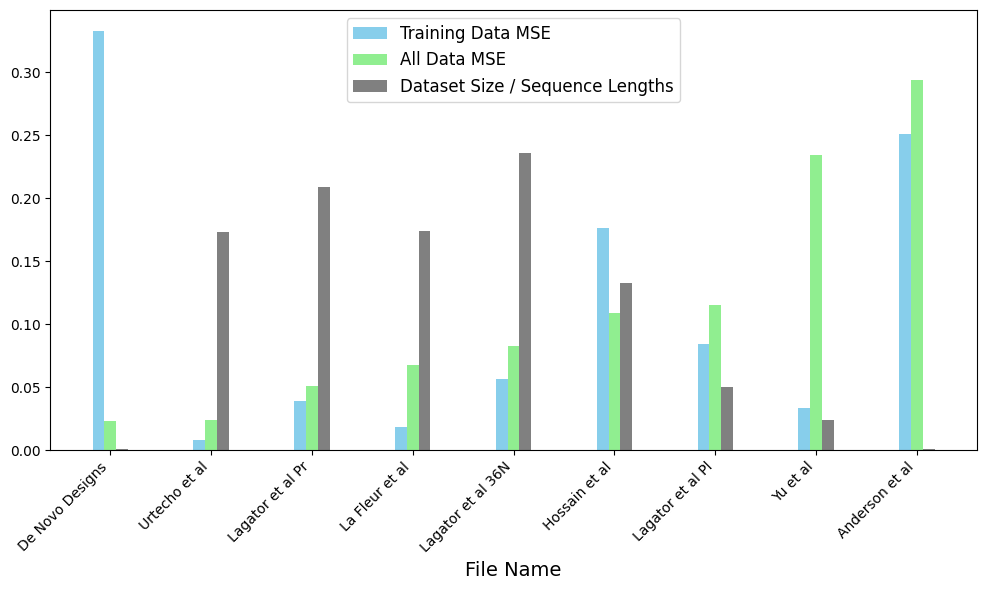

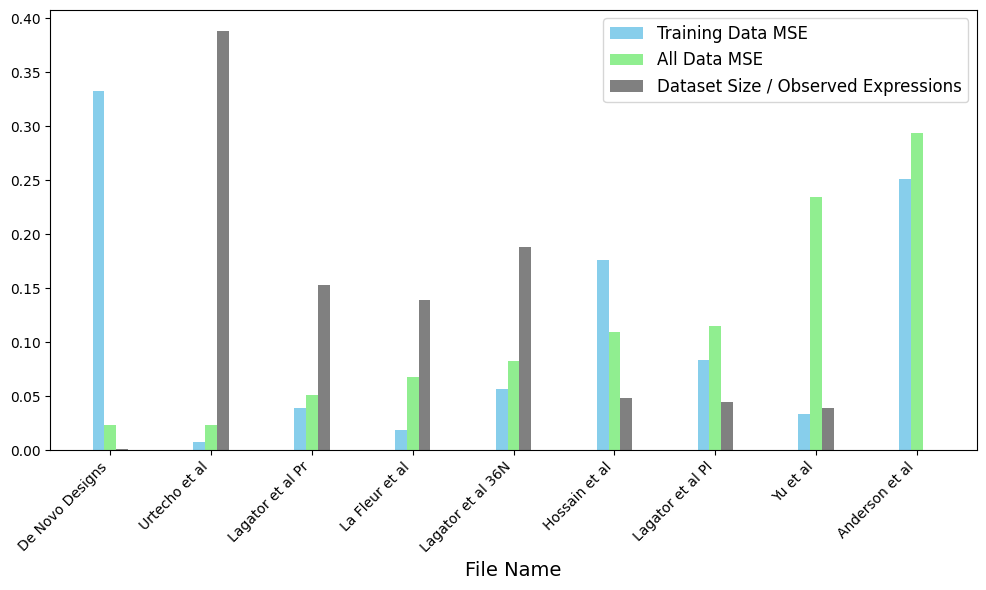

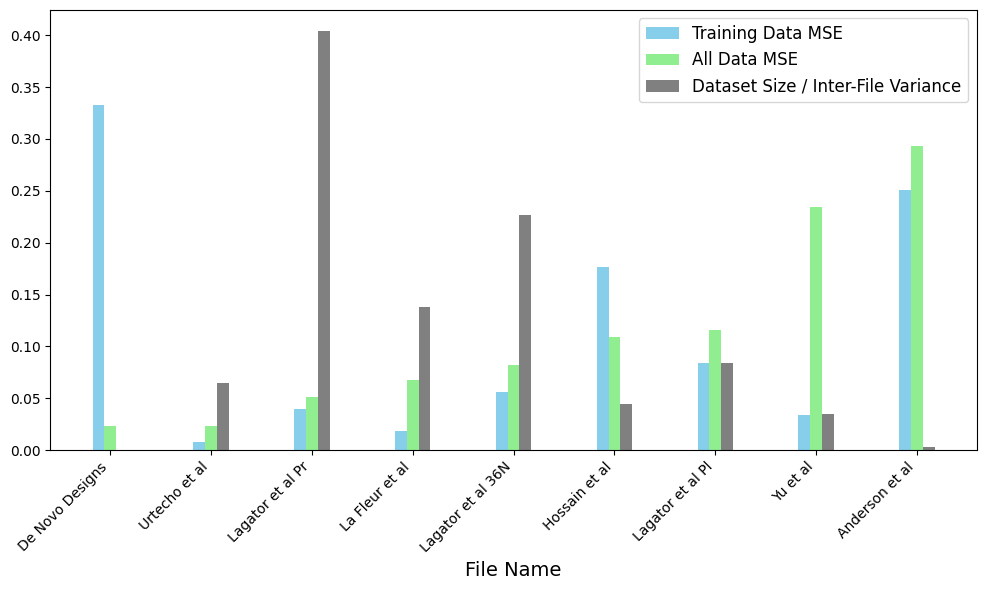

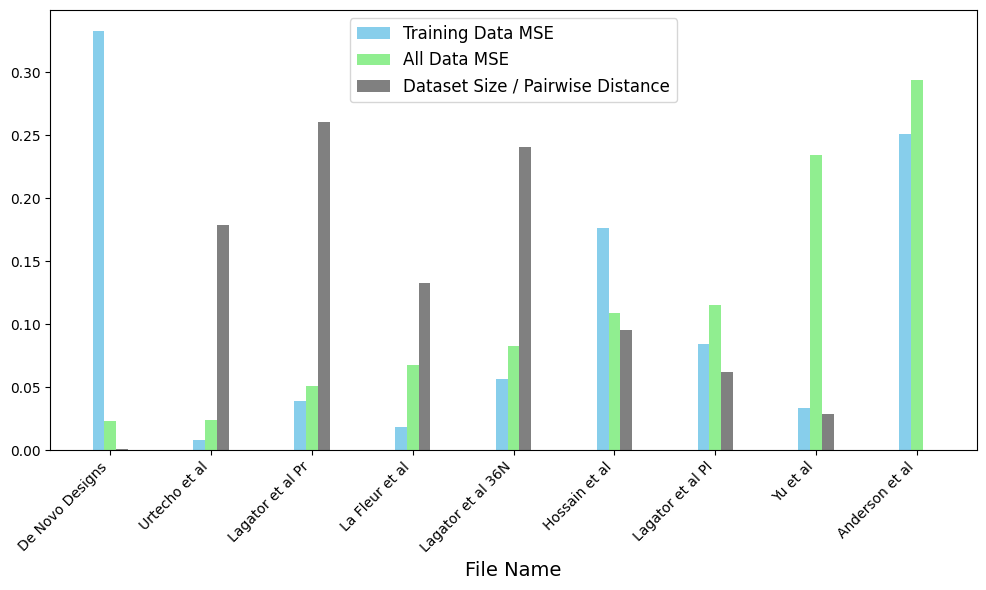

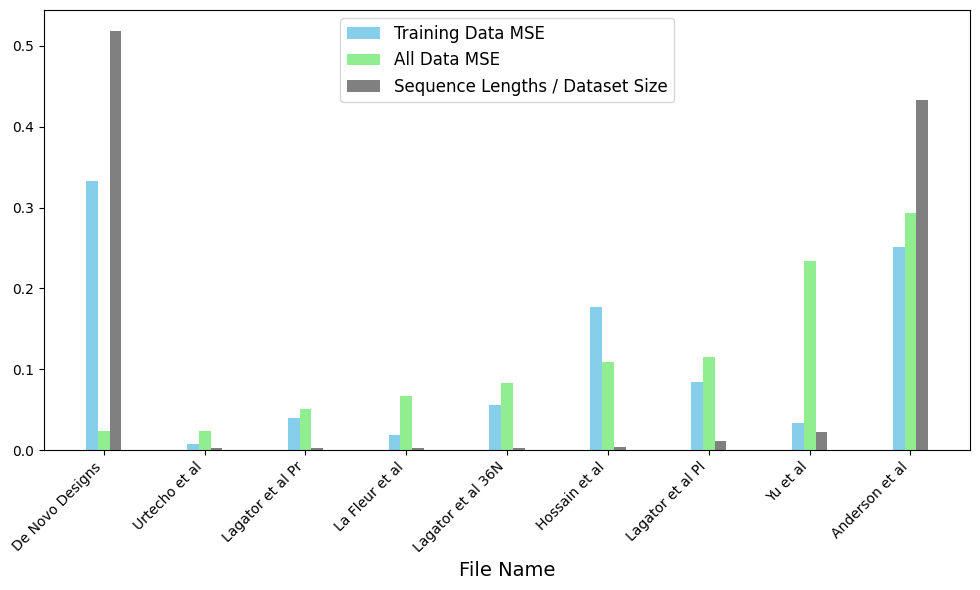

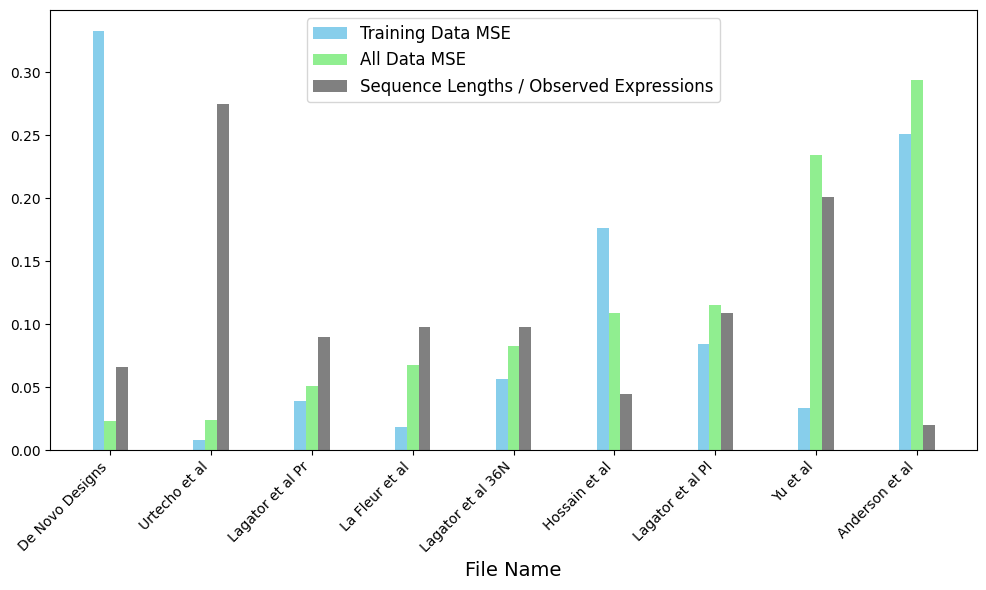

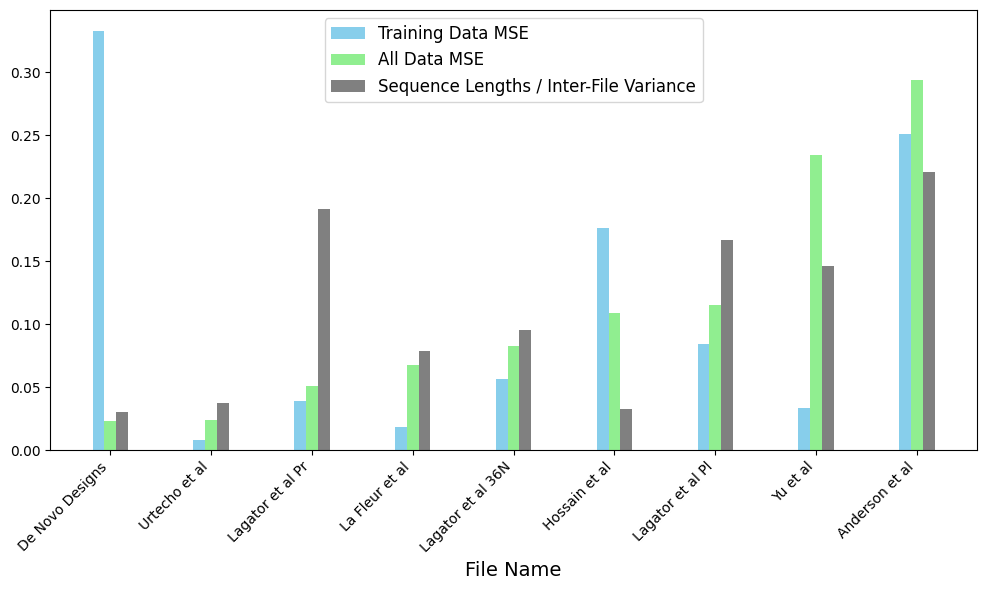

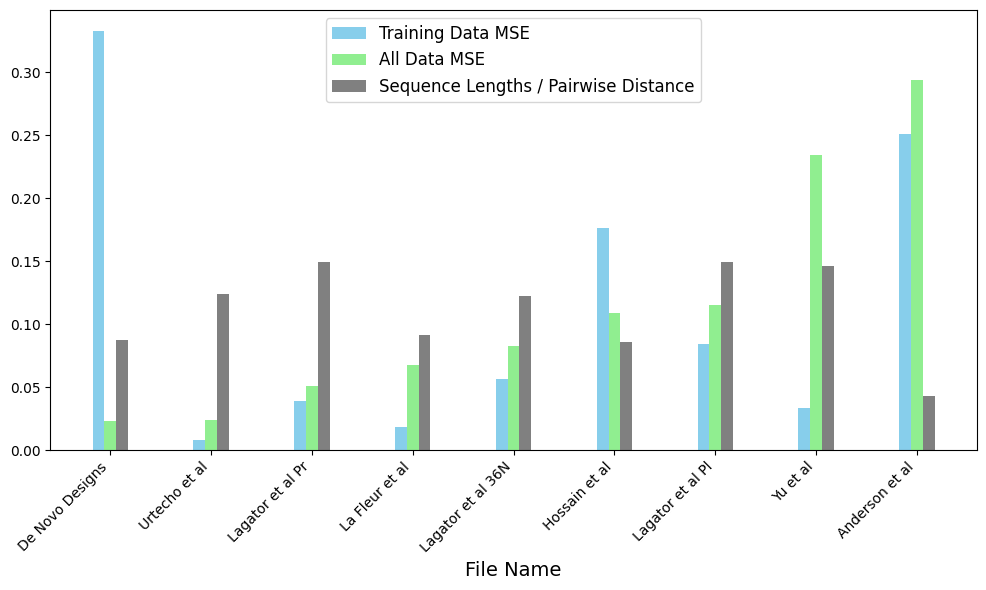

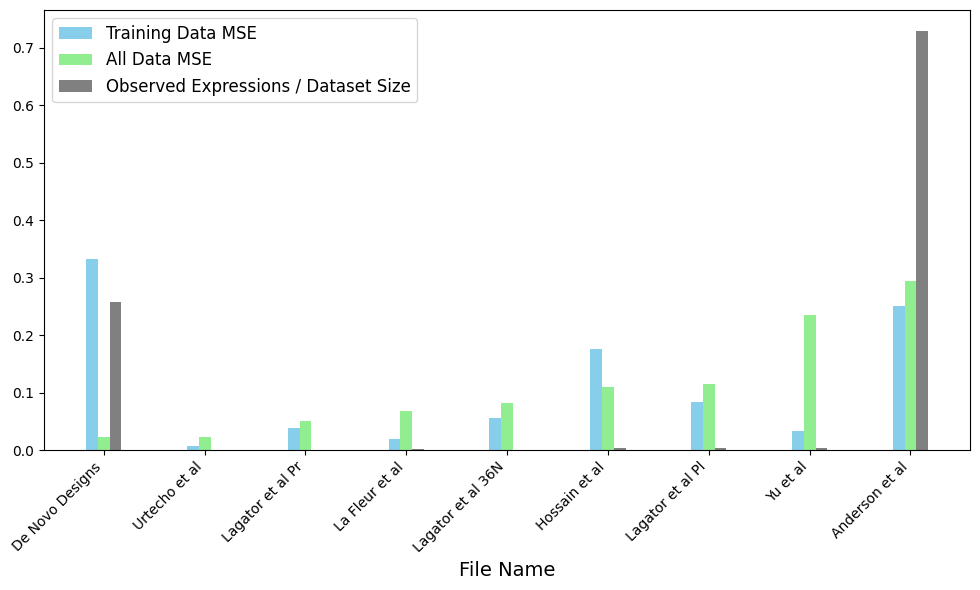

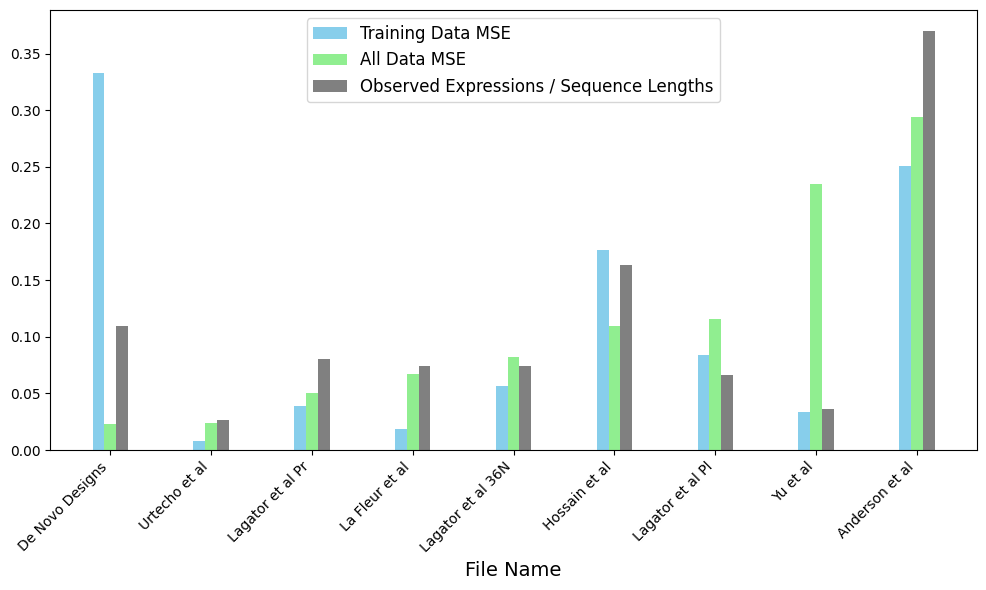

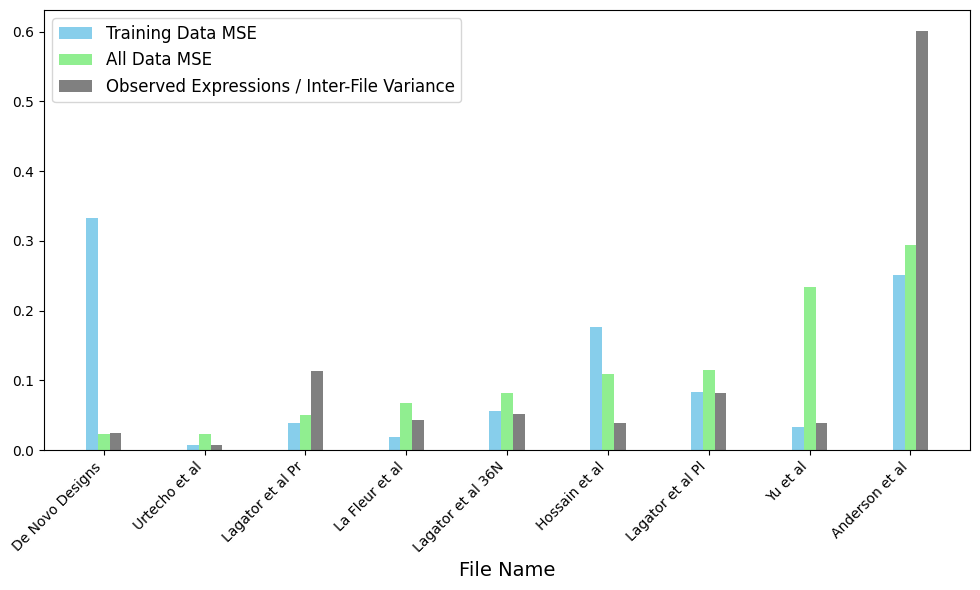

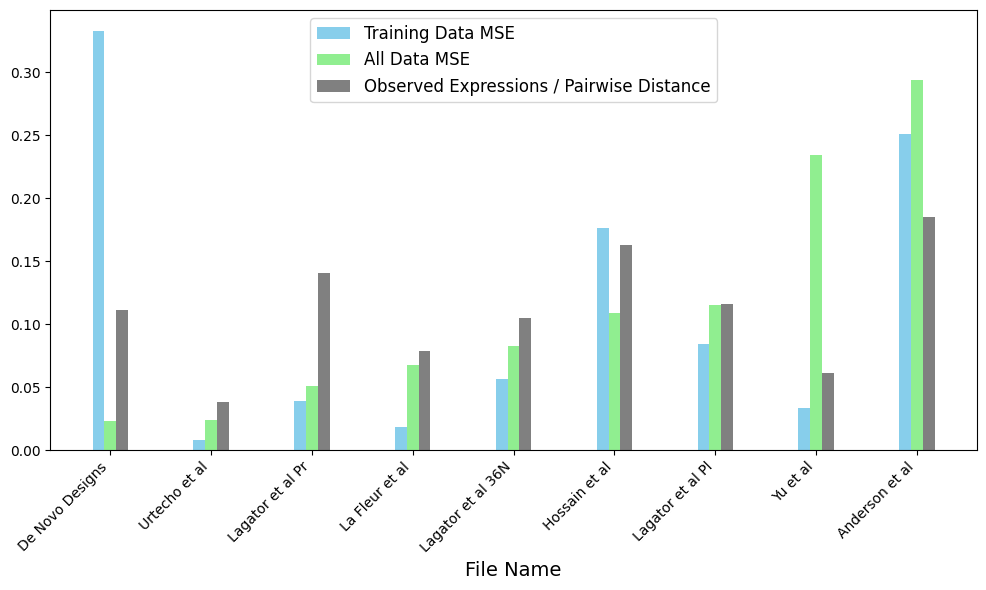

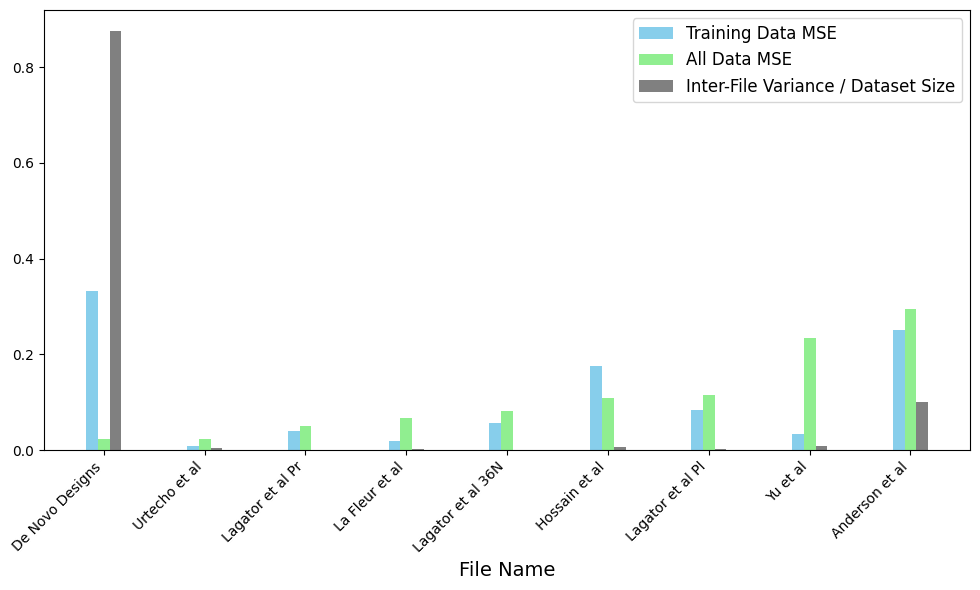

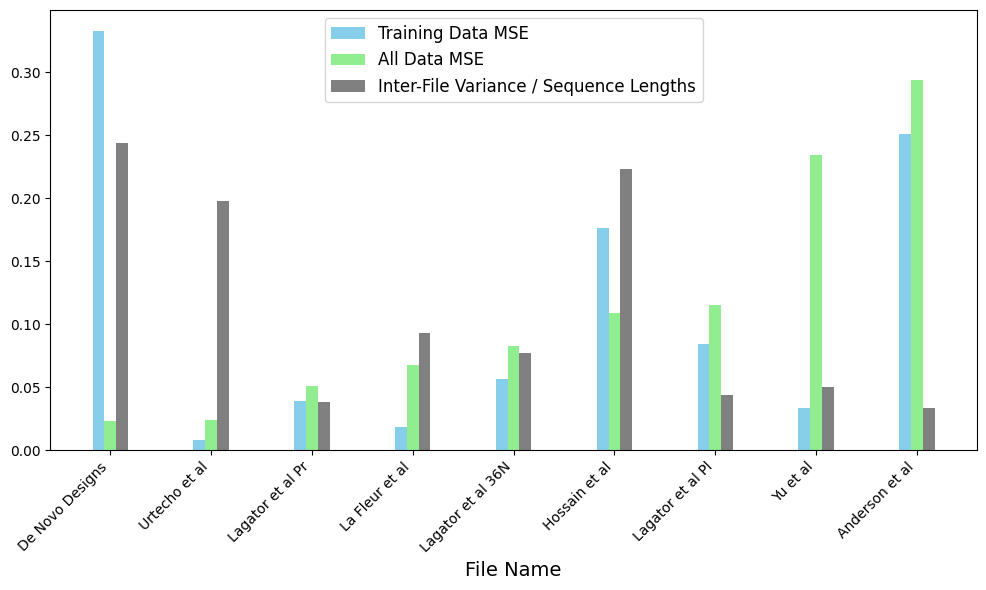

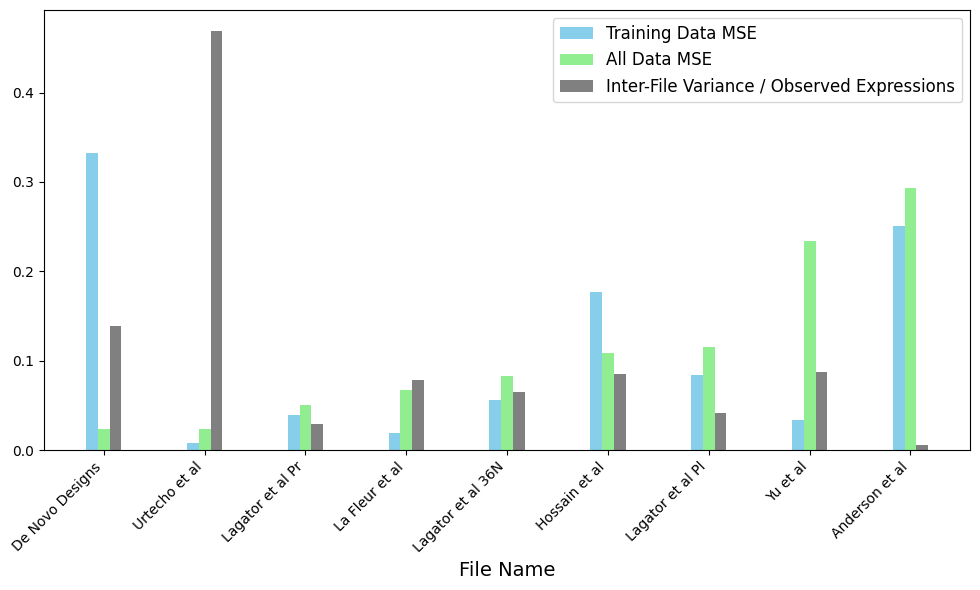

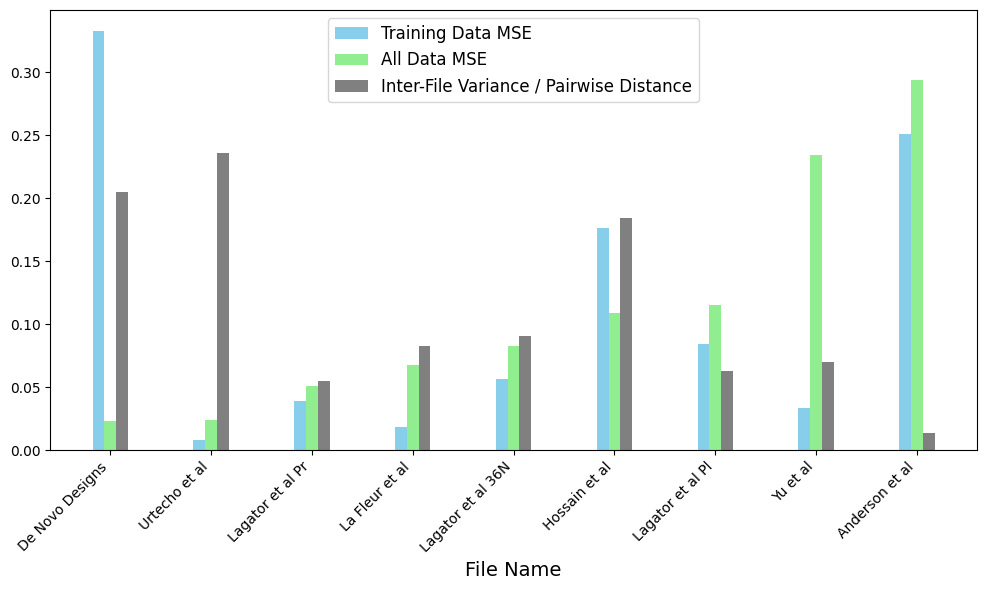

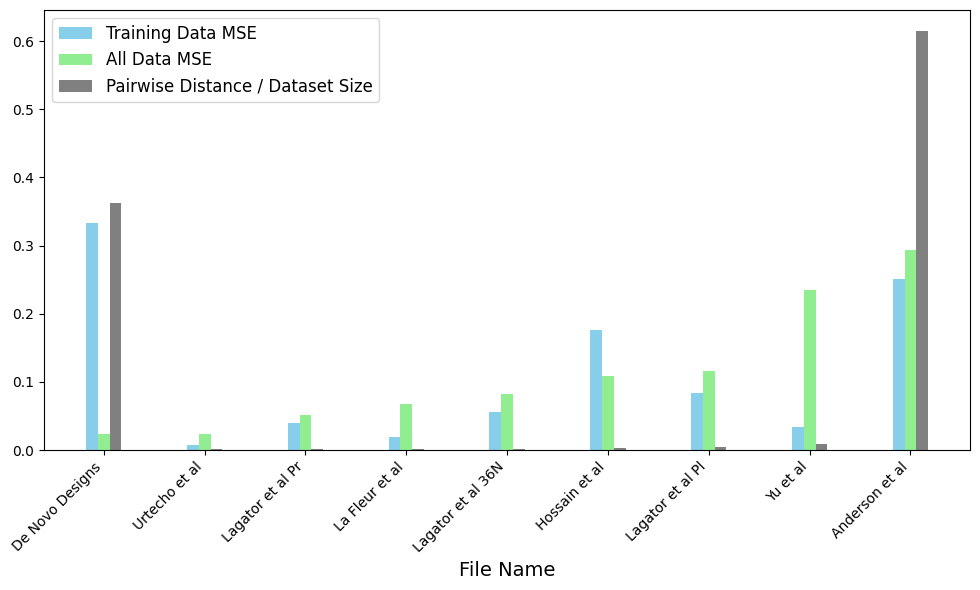

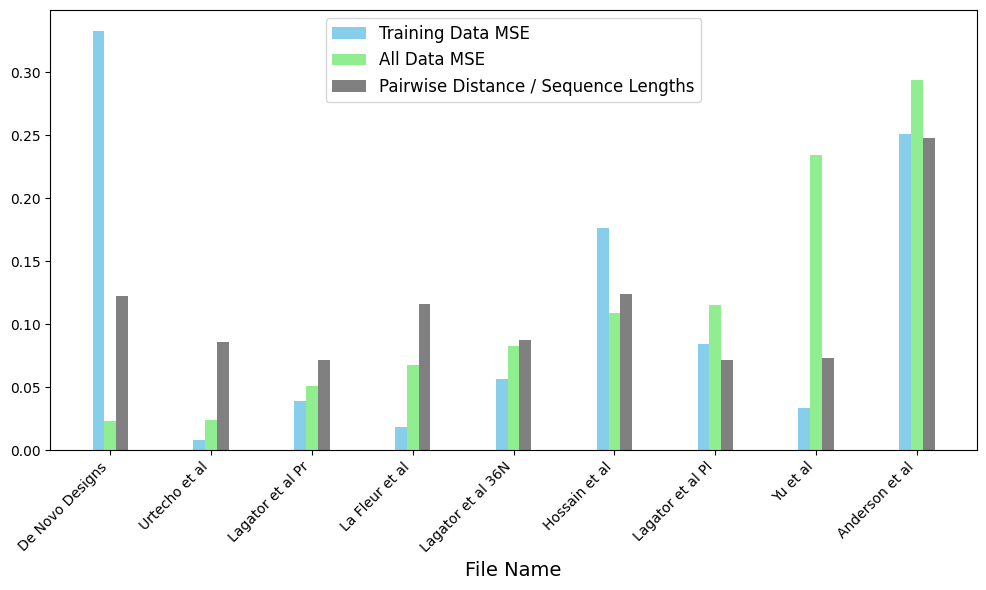

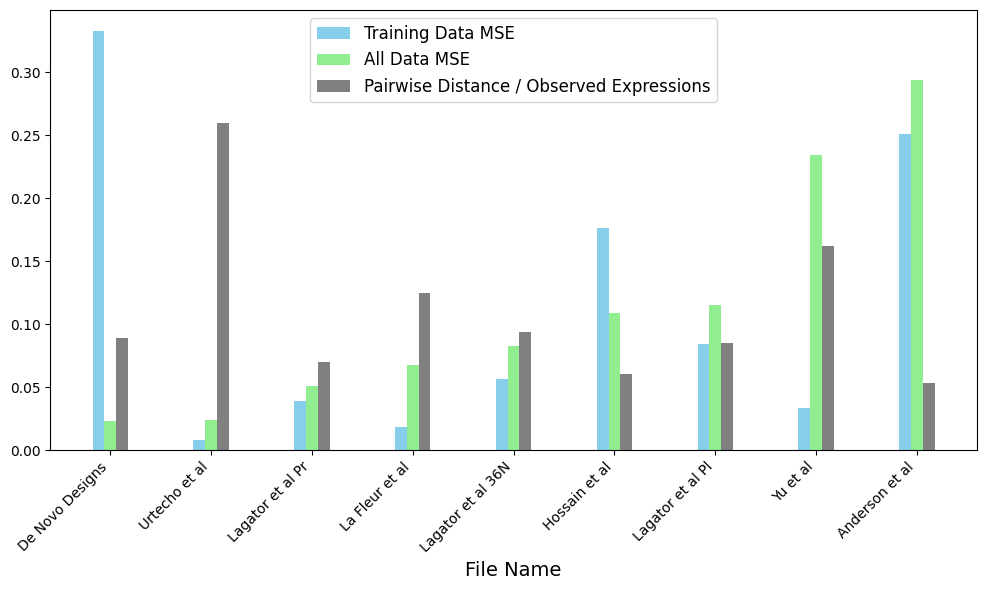

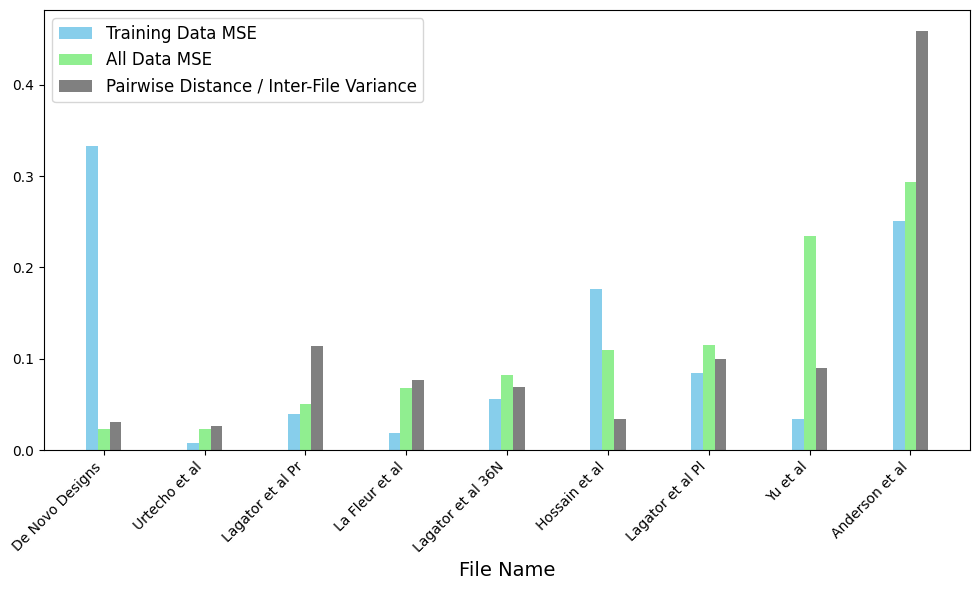

In [17]:
metrics = {
    'Dataset Size' : file_sequence_counts,
    'Sequence Lengths' : average_sequence_lengths,
    'Observed Expressions' : average_observed_expressions,
    'Inter-File Variance' : inter_file_variance,
    'Pairwise Distance' : average_pairwise_distances,
}

individual_files_module.plot_relative_data(metrics, file_order, all_results)

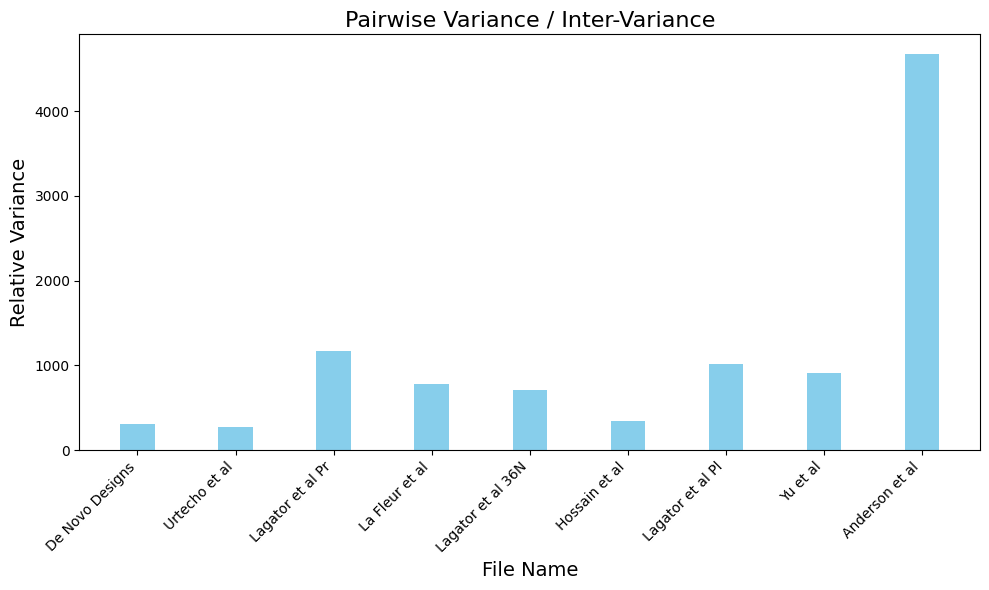

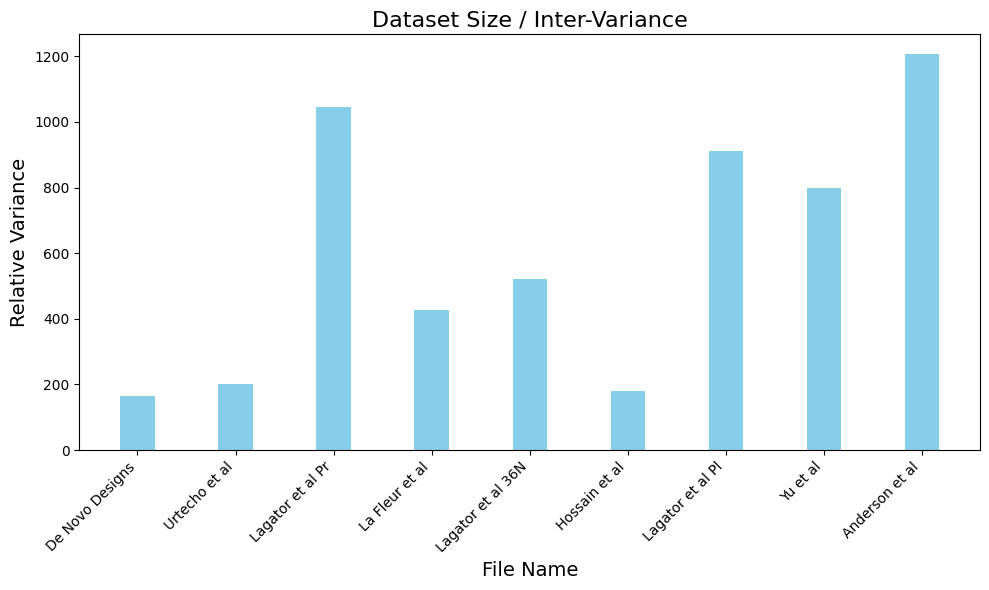

In [22]:
relative_variance = {}
for file in file_order:
    relative_variance[file] = average_pairwise_distances[file] / inter_file_variance[file]

individual_files_module.file_bar_chart(relative_variance, file_order, y_label='Relative Variance', title='Pairwise Variance / Inter-Variance')

relative_variance = {}
for file in file_order:
    relative_variance[file] = average_sequence_lengths[file] / inter_file_variance[file]

individual_files_module.file_bar_chart(relative_variance, file_order, y_label='Relative Variance', title='Dataset Size / Inter-Variance')